In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
import xarray as xr

In [4]:
from file_processing import get_netcdf_files, get_rhime_outs

In [5]:
from country_totals import get_country_trace, get_x_to_country_mat

In [6]:
from country_totals import get_xr_dummies, sparse_xr_dot, make_quantiles

In [7]:
#!pip install sparse

In [ ]:
species = "sf6"

files = get_netcdf_files("/home/brendan/Documents/inversions/plotting/sf6_best")

outs = get_rhime_outs(files)

In [11]:
countries = xr.open_dataset("/home/brendan/Documents/inversions/openghg_inversions/countries/country_EUROPE.nc")

In [12]:
countries_ukmo = xr.open_dataset("/home/brendan/Documents/inversions/openghg_inversions/countries/country-ukmo_EUROPE.nc")

In [13]:
x_to_country_mats = [get_x_to_country_mat(countries, ds, sparse=True) for ds in outs]
x_to_country_mats_ukmo = [get_x_to_country_mat(countries_ukmo, ds, sparse=True) for ds in outs]

In [14]:
country_traces = [get_country_trace(countries, species, hbmcmc_outs=ds, x_to_country=mat) for ds, mat in zip(outs, x_to_country_mats)]

In [15]:
country_traces_ukmo = [get_country_trace(countries_ukmo, species, hbmcmc_outs=ds, x_to_country=mat) for ds, mat in zip(outs, x_to_country_mats_ukmo)]

In [16]:
country_traces = [trace.expand_dims({"time": [out_ds.Ytime.min().values]}) for trace, out_ds in zip(country_traces, outs)]
country_trace_ds = xr.concat(country_traces, dim="time")

In [17]:
country_traces_ukmo = [trace.expand_dims({"time": [out_ds.Ytime.min().values]}) for trace, out_ds in zip(country_traces_ukmo, outs)]
country_trace_ukmo_ds = xr.concat(country_traces_ukmo, dim="time")

# Getting country prior traces

In [18]:
min_model_error = 0.15

In [197]:
from flux_output_format import get_prior_samples

In [198]:
idatas = [get_prior_samples(ds, min_model_error=min_model_error) for ds in outs]

Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]


In [199]:
idatas[0]

Inference data with groups:
	> prior

In [21]:
prior_x_traces = [idata.prior.x.isel(chain=0).rename({"x_dim_0": "basis_region"}) for idata in idatas]
country_prior_traces = [get_country_trace(countries, species, hbmcmc_outs=ds, x_to_country=mat, x_trace=xtrace) for ds, xtrace, mat in zip(outs, prior_x_traces, x_to_country_mats)]
country_prior_traces_ukmo = [get_country_trace(countries_ukmo, species, hbmcmc_outs=ds, x_to_country=mat, x_trace=xtrace) for ds, xtrace, mat in zip(outs, prior_x_traces, x_to_country_mats_ukmo)]

In [22]:
country_prior_traces = [trace.expand_dims({"time": [out_ds.Ytime.min().values]}) for trace, out_ds in zip(country_prior_traces, outs)]
country_prior_trace_ds = xr.concat(country_prior_traces, dim="time")

In [23]:
country_prior_traces_ukmo = [trace.expand_dims({"time": [out_ds.Ytime.min().values]}) for trace, out_ds in zip(country_prior_traces_ukmo, outs)]
country_prior_trace_ukmo_ds = xr.concat(country_prior_traces_ukmo, dim="time")

In [24]:
country_merged_ds = xr.merge([
    country_prior_trace_ds.mean("draw").rename("countryapriori"), 
    make_quantiles(country_prior_trace_ds, sample_dim="draw").rename("pcountryapriori"),
    country_trace_ds.mean("steps").rename("countryapost"), 
    make_quantiles(country_trace_ds).rename("pcountryapost"),
])

country_ukmo_merged_ds = xr.merge([
    country_prior_trace_ukmo_ds.mean("draw").rename("countryapriori"), 
    make_quantiles(country_prior_trace_ukmo_ds, sample_dim="draw").rename("pcountryapriori"),
    country_trace_ukmo_ds.mean("steps").rename("countryapost"), 
    make_quantiles(country_trace_ukmo_ds).rename("pcountryapost"),
])

# Process flux

We can't use the same method (producing flux traces) because they would be massing... 1000 samples for the EUROPE domain would be several gigabytes.

Since the flux is constant on the basis regions, we can compute means and quantiles before mapping them to the original lat/lon domain.

In [25]:
basis_mats = [get_xr_dummies(ds.basisfunctions, cat_dim="basis_region") for ds in outs]

In [26]:
fluxes = [ds.fluxapriori for ds in outs]
x_traces = [ds.xtrace.rename({"nparam": "basis_region"}) for ds in outs]

In [27]:
x_means = [trace.mean("steps") for trace in x_traces]
x_quantiles = [make_quantiles(trace) for trace in x_traces]

In [28]:
flux_means = [sparse_xr_dot(flux * mat, mean) for flux, mean, mat in zip(fluxes, x_means, basis_mats)] 

In [29]:
flux_quantiles = [sparse_xr_dot(flux * mat, quantiles) for flux, quantiles, mat in zip(fluxes, x_quantiles, basis_mats)] 

In [30]:
prior_x_means = [trace.mean("draw") for trace in prior_x_traces]
prior_x_quantiles = [make_quantiles(trace, sample_dim="draw") for trace in prior_x_traces]

In [31]:
prior_flux_means = [sparse_xr_dot(flux * mat, mean) for flux, mean, mat in zip(fluxes, prior_x_means, basis_mats)] 

In [32]:
prior_flux_quantiles = [sparse_xr_dot(flux * mat, quantiles) for flux, quantiles, mat in zip(fluxes, prior_x_quantiles, basis_mats)] 

In [33]:
times = [ds.Ytime.min().values for ds in outs]

In [34]:
prior_flux_mean_ds = xr.concat([da.expand_dims({"time": [time]}) for da, time in zip(prior_flux_means, times)], dim="time")
flux_mean_ds = xr.concat([da.expand_dims({"time": [time]}) for da, time in zip(flux_means, times)], dim="time")

In [35]:
prior_flux_quantile_ds = xr.concat([da.expand_dims({"time": [time]}) for da, time in zip(prior_flux_quantiles, times)], dim="time")
flux_quantile_ds = xr.concat([da.expand_dims({"time": [time]}) for da, time in zip(flux_quantiles, times)], dim="time")

In [36]:
flux_merged_ds = xr.merge([
    prior_flux_mean_ds.rename("fluxapriori"),
    prior_flux_quantile_ds.rename("pfluxapriori"),
    flux_mean_ds.rename("fluxapost"),
    flux_quantile_ds.rename("pfluxapost")
])

## Testing mode finding code

In [124]:
from helpers import calc_mode

In [57]:
from scipy import stats
import matplotlib.pyplot as plt

In [39]:
len(x_traces)

11

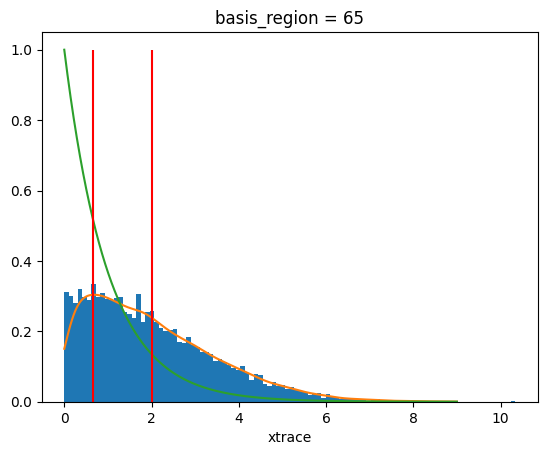

In [92]:
xtr = x_traces[0].isel(basis_region=65)
xtr.plot.hist(density=True, bins=100)
xs = np.linspace(0.0, 9.0, 500)
kde = stats.gaussian_kde(xtr.values)
plt.plot(xs, kde.evaluate(xs))
plt.plot(xs, stats.expon.pdf(xs))
plt.vlines(xtr.mean(), 0, 1, color="r")
plt.vlines(0.65, 0, 1, color="r")

Maybe basis region 0 isn't the best to use... for MAP, my prior would act like LASSO and set most of the modes to 0...

Basis region 65 seems to have departed significantly from the prior, so we'll use that.

In [75]:
x_qs = make_quantiles(x_traces[0], probs=np.linspace(0.0, 1.0, 100))

In [64]:
exp_qs = stats.expon.ppf(np.linspace(0.0, 1.0, 100))

In [74]:
exp_qs

array([0.        , 0.01015237, 0.02040887, 0.03077166, 0.04124296,
       0.05182507, 0.06252036, 0.07333127, 0.08426034, 0.09531018,
       0.10648348, 0.11778304, 0.12921173, 0.14077255, 0.15246859,
       0.16430305, 0.17627924, 0.1884006 , 0.2006707 , 0.21309322,
       0.225672  , 0.23841102, 0.25131443, 0.26438651, 0.27763174,
       0.29105476, 0.30466041, 0.31845373, 0.33243997, 0.34662461,
       0.36101335, 0.37561214, 0.39042723, 0.40546511, 0.42073258,
       0.43623677, 0.45198512, 0.46798547, 0.48424599, 0.50077529,
       0.51758241, 0.53467684, 0.55206858, 0.56976816, 0.58778666,
       0.6061358 , 0.62482794, 0.64387613, 0.66329422, 0.68309684,
       0.70329955, 0.72391884, 0.74497225, 0.76647845, 0.78845736,
       0.81093022, 0.83391973, 0.85745023, 0.88154778, 0.9062404 ,
       0.9315582 , 0.95753369, 0.98420194, 1.01160091, 1.03977179,
       1.06875933, 1.09861229, 1.12938395, 1.16113265, 1.19392247,
       1.22782402, 1.26291534, 1.29928298, 1.33702331, 1.37624

In [73]:
x_qs.isel(basis_region=0)

<xarray.DataArray (probs: 100)>
array([7.23943217e-05, 9.79401297e-04, 1.65071061e-03, 3.24956774e-03,
       3.84911316e-03, 4.49169359e-03, 5.65418597e-03, 6.50564541e-03,
       7.19616201e-03, 7.91832157e-03, 9.39692715e-03, 1.04028376e-02,
       1.13248691e-02, 1.19983997e-02, 1.25667202e-02, 1.30995149e-02,
       1.45396342e-02, 1.57107831e-02, 1.62909779e-02, 1.68499170e-02,
       1.77801983e-02, 1.93404341e-02, 1.96691566e-02, 2.13103533e-02,
       2.22783043e-02, 2.35732744e-02, 2.47751251e-02, 2.57288584e-02,
       2.65736775e-02, 2.81190408e-02, 2.89522935e-02, 2.99387561e-02,
       3.11358114e-02, 3.21442321e-02, 3.36530232e-02, 3.44638019e-02,
       3.50222365e-02, 3.60158107e-02, 3.70018078e-02, 3.77773233e-02,
       3.83031615e-02, 3.98015404e-02, 4.09026576e-02, 4.16569347e-02,
       4.26830064e-02, 4.39202394e-02, 4.43552323e-02, 4.63319318e-02,
       4.74911364e-02, 4.81289890e-02, 4.91054861e-02, 4.97743666e-02,
       5.07659608e-02, 5.18417487e-02, 5.27539341e-02, 5.37867029e-02,
       5.54242162e-02, 5.67906285e-02, 5.75347396e-02, 5.83843922e-02,
       6.01342638e-02, 6.07086234e-02, 6.18535641e-02, 6.22910225e-02,
       6.35673516e-02, 6.48364311e-02, 6.59305910e-02, 6.69643743e-02,
       6.76522929e-02, 6.89536061e-02, 7.00536710e-02, 7.13125765e-02,
       7.21910025e-02, 7.34906979e-02, 7.45352018e-02, 7.56719420e-02,
       7.66396470e-02, 7.79628301e-02, 7.90776209e-02, 8.05746736e-02,
       8.15431078e-02, 8.29800339e-02, 8.43617073e-02, 8.56381204e-02,
       8.68660136e-02, 8.77270797e-02, 8.86335228e-02, 8.93203125e-02,
       9.04498541e-02, 9.14951000e-02, 9.22879730e-02, 9.33922106e-02,
       9.41575670e-02, 9.50220163e-02, 9.60707749e-02, 9.66592128e-02,
       9.75529347e-02, 9.87734722e-02, 1.00362676e-01, 1.00941740e-01])
Coordinates:
    basis_region  int64 0
  * probs         (probs) float64 0.0 0.00101 0.00202 ... 0.09798 0.09899 0.1

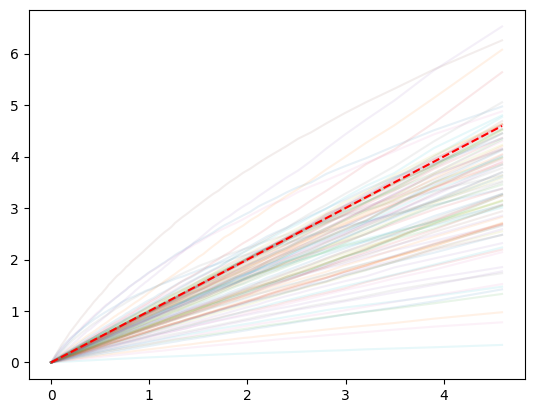

In [78]:
for i in range(x_qs.sizes["basis_region"]):
    plt.plot(exp_qs, x_qs.isel(basis_region=i).values, alpha=0.1)
plt.plot(exp_qs, exp_qs, "--", color="r")

In [85]:
np.argmax(np.mean(x_qs.values[:-1, :] - exp_qs.reshape((-1, 1))[:-1,:], axis=0))

65

In [94]:
%%timeit
print(float(calc_mode(x_traces[0]).isel(basis_region=65)))

0.6758018264274641
0.6758018264274641
0.6758018264274641
0.6758018264274641
0.6758018264274641
0.6758018264274641
0.6758018264274641
0.6758018264274641
2.58 s ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So over 30 seconds for a year of data, but this is with < 100 basis regions. It would be over 2.5 minutes for 500 basis functions.

In [90]:
%%timeit
print(float(calc_mode(x_traces[0].isel(steps=np.random.choice(10000, 3000))).isel(basis_region=65)))

0.6848307844720456
0.6768865101427214
0.6968111610205046
0.8583684203827456
0.6958205756640526
0.9449935306132066
0.596706038052395
0.6576175679059966
655 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We could try to parallelise this computation with dask...

In [147]:
from file_processing import nmeasure_to_site_and_time

In [144]:
xtr_dask = x_traces[0].chunk({"basis_region": 10})

In [145]:
%%timeit
calc_mode(xtr_dask)

1.8 ms ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [146]:
%%timeit
calc_mode(x_traces[0])

2.54 s ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Merge all

In [84]:
paris_countries = ["IRELAND", "UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND", 
                   #"FRANCE", 
             "BELGIUM", "NETHERLANDS",
                   #"GERMANY",
                   "DENMARK", "SWITZERLAND", "AUSTRIA", "ITALY", 
             "CZECHIA", "POLAND", "HUNGARY", "SLOVAKIA", "NORWAY", "SWEDEN", "FINLAND"]

In [85]:
country_filt = country_merged_ds.country.isin(paris_countries)

In [86]:
country_ukmo_merged_ds.country.values

array(['None', 'RestEU', 'IRELAND', 'FRANCE', 'BENELUX', 'Sea', 'Sea',
       'Sea', 'Sea', 'GERMANY', 'Sea', 'DENMARK', 'SpaPor', 'NORWAY',
       'Sea', 'Sea', 'Sea', 'Sea', 'NE.EU', 'UNITED KINGDOM'],
      dtype='<U14')

In [87]:
country_ukmo_filt = country_ukmo_merged_ds.country.isin(["BENELUX", "RestEU", "SpaPor", "UNITED KINGDOM", "FRANCE", "GERMANY"])

In [88]:
country_final_ds = xr.concat([country_merged_ds.where(country_filt, drop=True), country_ukmo_merged_ds.where(country_ukmo_filt, drop=True)], dim="ncountries")

In [89]:
rhime_emissions = xr.merge([flux_merged_ds, country_final_ds]).drop_vars("chain")

In [90]:
rhime_emissions.country.values

array(['UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND',
       'SWITZERLAND', 'SWEDEN', 'SLOVAKIA', 'POLAND', 'NORWAY',
       'NETHERLANDS', 'ITALY', 'IRELAND', 'HUNGARY', 'FINLAND', 'DENMARK',
       'CZECHIA', 'BELGIUM', 'AUSTRIA', 'RestEU', 'FRANCE', 'BENELUX',
       'GERMANY', 'SpaPor', 'UNITED KINGDOM'], dtype='<U52')

In [91]:
from pathlib import Path

In [92]:
output_path = Path("/home/brendan/Documents/inversions/plotting/")
output_filename = "sf6_rhime_emissions_nbasis100.nc"

rhime_emissions.to_netcdf(output_path / output_filename)

# Plotting

In [220]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'SF$_6$ (Gg y$^{-1}$)')

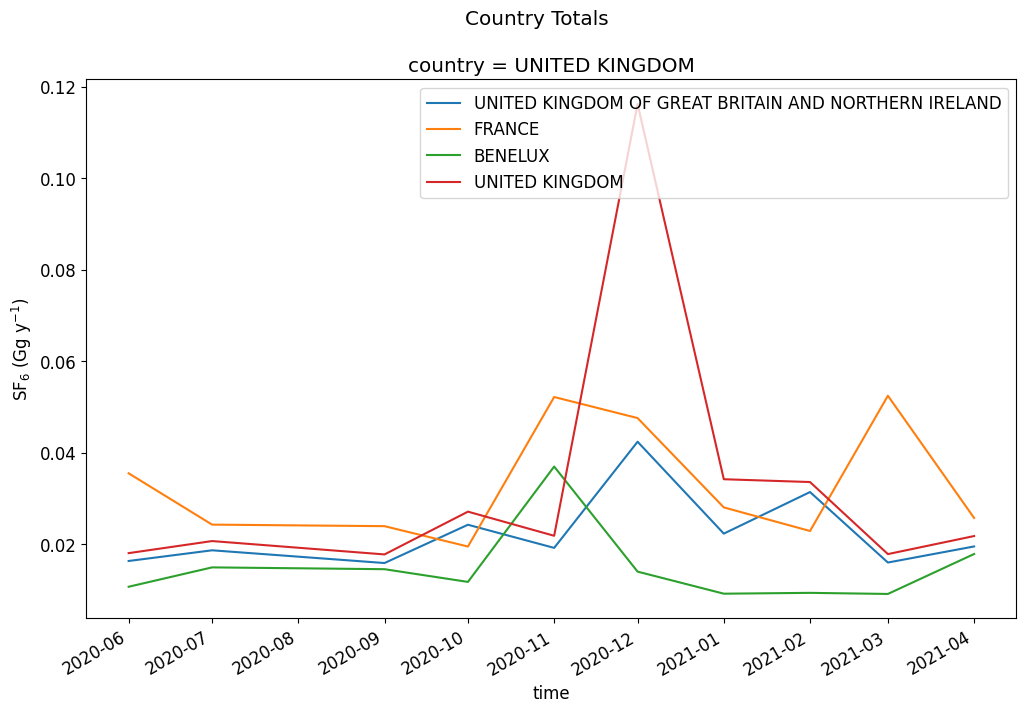

In [221]:
countries_to_plot = ["UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND", "FRANCE", "BENELUX", "UNITED KINGDOM"]
filt = rhime_emissions.country.isin(countries_to_plot)

fig, ax = plt.subplots(figsize=(12,7))

for i, country in enumerate(countries_to_plot):
    (1e-9 * rhime_emissions.countryapost.where(filt, drop=True).isel(ncountries=i)).plot(ax=ax, label=country)

ax.legend()
fig.suptitle("Country Totals")
ax.set_ylabel('SF$_6$ (Gg y$^{-1}$)')

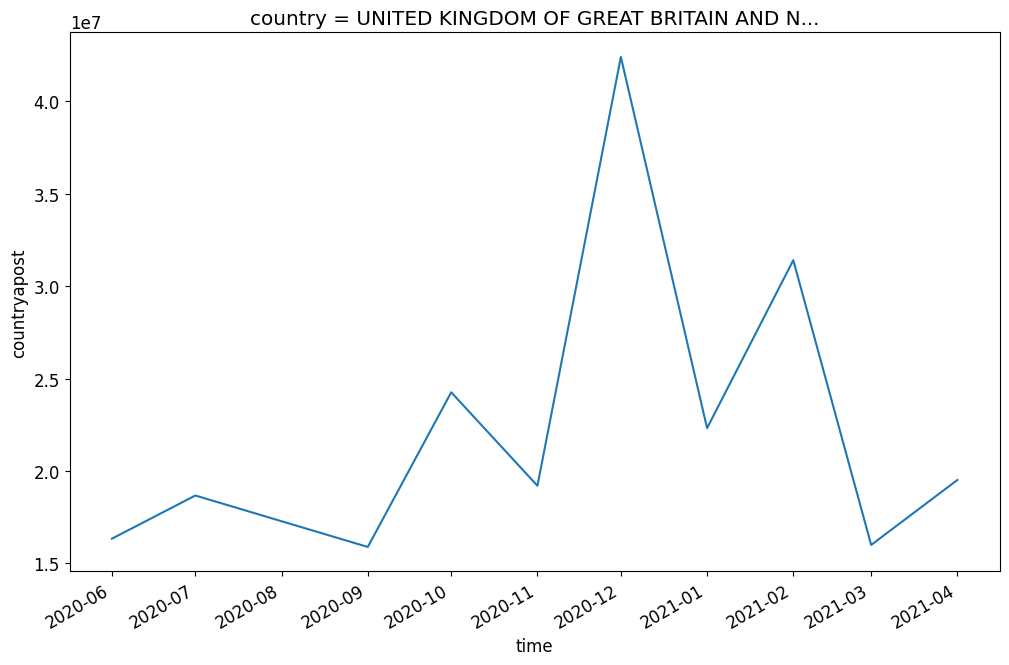

In [222]:
fig, ax = plt.subplots(figsize=(12,7))

rhime_emissions.countryapost.isel(ncountries=0).plot()

In [223]:
colors = ['navy','firebrick','dodgerblue','darkorange']
font = {'size':12}
plt.rc('font', **font)

def plot_timeseries(time, values, uncert_lower=None, uncert_upper=None, color=None, label=None, ax=None, monthly=True, errorbar=True, **kwargs):
    """Plot time series"""
    if ax is None:
        ax = plt.gca()
    plot_kwargs = kwargs
    if color:
        plot_kwargs['color'] = color
    if label:
        plot_kwargs['label'] = label
    if monthly:
        time = time.astype('datetime64[M]')
    ax.plot(time, values, **plot_kwargs)
    if label:
        del plot_kwargs['label']
    if uncert_lower is not None and uncert_upper is not None:
        if errorbar:
            ax.errorbar(time, values, yerr=[values - uncert_lower, uncert_upper - values], marker='o', alpha=0.6, **plot_kwargs)
        ax.fill_between(time, uncert_lower, uncert_upper, alpha=0.2, **plot_kwargs)

Text(0, 0.5, 'SF$_6$ (Gg y$^{-1}$)')

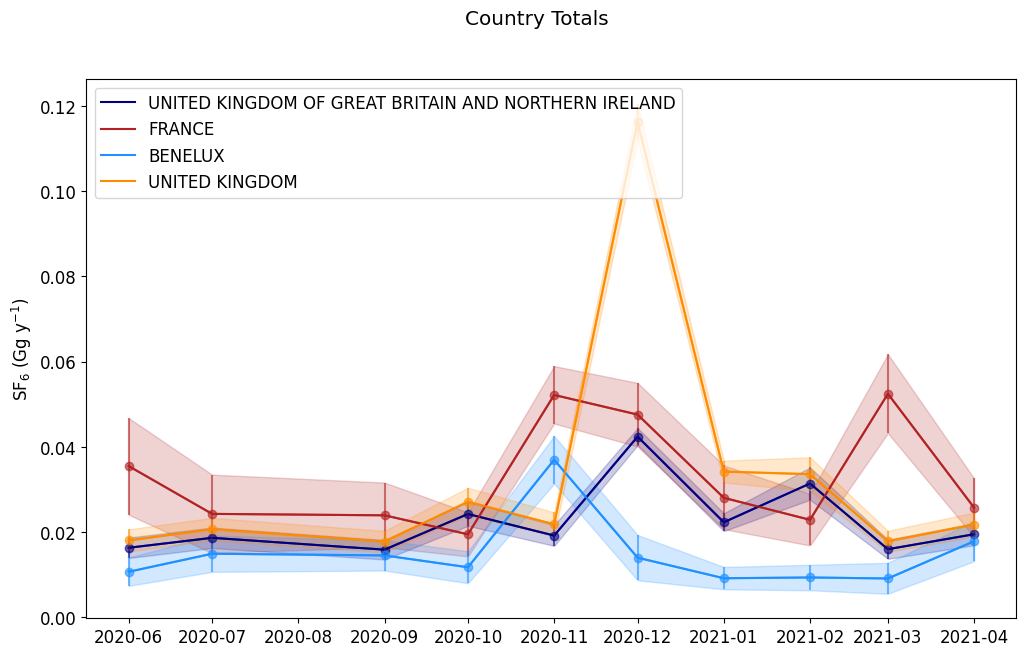

In [224]:
fig, ax = plt.subplots(figsize=(12,7))

for i, country in enumerate(countries_to_plot):
    ds = 1e-9 * rhime_emissions.where(filt, drop=True).isel(ncountries=i)
    plot_timeseries(ds.time.values, ds.countryapost.values, uncert_lower=ds.pcountryapost[1].values, uncert_upper=ds.pcountryapost[2].values, label=country, color=colors[i])

ax.legend(loc="upper left")
fig.suptitle("Country Totals")
ax.set_ylabel('SF$_6$ (Gg y$^{-1}$)')

In [225]:
dec2020 = rhime_emissions.sel(time="2020-12-01").where(rhime_emissions.lat > 40, drop=True).where(rhime_emissions.lon > -20, drop=True)

/home/brendan/Documents/inversions/.pymc_venv/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


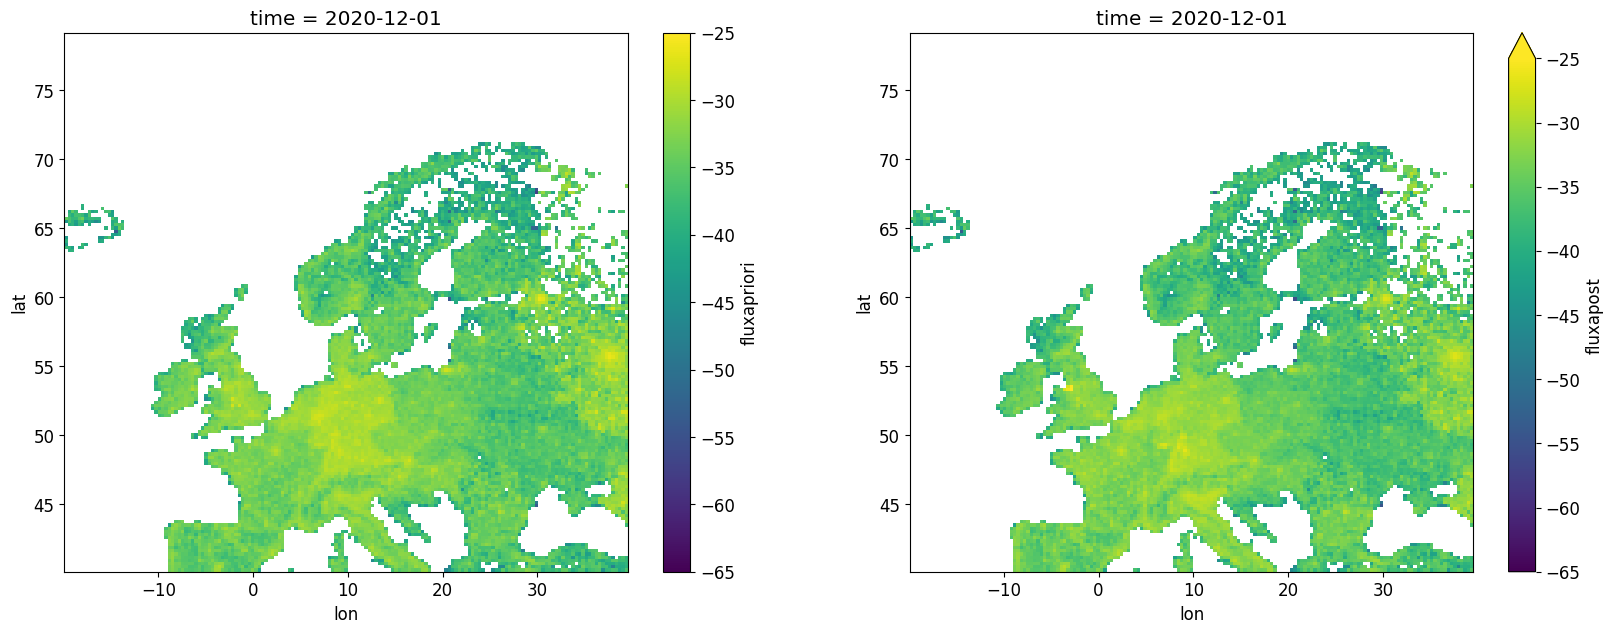

In [226]:
fig, axs = plt.subplots(1, 2, figsize=(20,7))

ax = axs.flat[1]
np.log(dec2020.fluxapost).plot(ax=ax, label="posterior flux", vmin=-65, vmax=-25)

ax = axs.flat[0]
np.log(dec2020.fluxapriori).plot(ax=ax, label="prior flux", vmin=-65, vmax=-25)

# Concentrations processing

## quantiles, HDI

In [148]:
import arviz as az

In [176]:
xq0 = x_traces[0].quantile([0.025, 0.159, 0.841, 0.975], dim="steps")

In [174]:
hdi95 = az.hdi(idatas[0], group="prior", hdi_prob=0.95)
hdi95 = hdi95.assign_coords(hdi=(hdi95.hdi.str + "95"))
hdi68 = az.hdi(idatas[0], group="prior", hdi_prob=0.68)
hdi68 = hdi68.assign_coords(hdi=(hdi68.hdi.str + "68"))

In [175]:
hdis = xr.concat([hdi68, hdi95], dim="hdi").sel(hdi=["lower95", "lower68", "higher68", "higher95"])
hdis

<xarray.Dataset>
Dimensions:      (nlatent: 97, hdi: 4, nmeasure: 877, nBC: 16, nsigma_site: 8,
                  nsigma_time: 4)
Coordinates:
  * nlatent      (nlatent) int64 0 1 2 3 4 5 6 7 8 ... 89 90 91 92 93 94 95 96
  * nmeasure     (nmeasure) int64 0 1 2 3 4 5 6 ... 870 871 872 873 874 875 876
  * nBC          (nBC) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * nsigma_site  (nsigma_site) int64 0 1 2 3 4 5 6 7
  * nsigma_time  (nsigma_time) int64 0 1 2 3
  * hdi          (hdi) <U8 'lower95' 'lower68' 'higher68' 'higher95'
Data variables:
    x            (nlatent, hdi) float64 0.01884 0.4149 1.953 ... 1.969 2.757
    ymod         (nmeasure, hdi) float64 8.867 9.727 11.45 ... 9.725 11.35 12.21
    bc           (nBC, hdi) float64 0.825 0.901 1.093 ... 0.905 1.099 1.188
    ymodbc       (nmeasure, hdi) float64 8.712 9.841 11.53 ... 9.692 11.32 11.99
    sigma        (nsigma_site, nsigma_time, hdi) float64 0.1159 ... 0.9847
    mu           (nmeasure, hdi) float64 8.876 9.721 11.41 ... 9.827 11.39 12.06
    muBC         (nmeasure, hdi) float64 8.835 9.701 11.38 ... 9.765 11.33 11.98

In [182]:
hdis.x.isel(nlatent=65).values

array([8.00924390e-04, 1.85394246e-01, 1.74827581e+00, 2.70501275e+00])

In [183]:
xq0.isel(basis_region=65)

<xarray.DataArray 'xtrace' (quantile: 4)>
array([0.07920049, 0.52738589, 3.53568983, 5.49548365])
Coordinates:
    basis_region  int64 65
  * quantile      (quantile) float64 0.025 0.159 0.841 0.975